## Introduction

The objectives of this notebook is to introduce the WMTS (Web Map Tile Service): the what, why and how to use one in Python.

There's a lot that can be learned about WMTS (see [here](http://opengeospatial.github.io/e-learning/wmts/text/main.html#introduction)) for more, but in this notebook, we'll cover just a few core concepts:

- WMTS is a structured way of viewing pictures of the earth in a web environment
- When you understand that structure, you can use a WMTS to pan around a map, or take advantage of it to grab the images that make up a map


## Getting started

One of the great things about Python is that due to its wide use, most of the code you need to write has probably already been written. Fortunately, when people realise their code is useful to others, they package it into modules and make them available. Some of these modules come standard with Python, others need to be installed.

The first thing to do is import more Python code from modules that were written to do specific tasks. In the cell below, we import two modules:
- requests: is used to request information from some place on the internet
- PIL: Python Image Library, for dealing with images

In [1]:
import requests
from PIL import Image

As mentioned above, WMTS is a structured way of viewing pictures of the earth. That structure is based on a grid of squares arranged in hierarchy. The lowest zoom level (zoom = 0) shows the whole earth in a square. To view the earth, we'll request data from Open Street Map and show that data as an image.

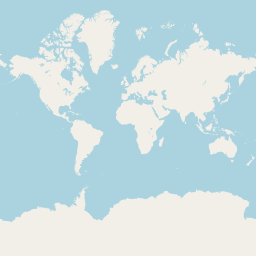

In [2]:
z, x, y = 0, 0, 0

# the url below uses Python's f-strings. Python converts f"{x}-{y}" to be "0-0", but dropping the f in front of the
# string would just be "{x}-{y}"
url = f"https://tile.openstreetmap.org/{z}/{x}/{y}.png"

response = requests.get(url, stream=True)
Image.open(response.raw)

Since API requests can really be boiled down to a URL, and your web browser is just a way of visiting URLs, you can click the URL below and see an image.

In [3]:
print(url)

https://tile.openstreetmap.org/0/0/0.png


To zoom in, we increase the zoom level. Let's try zoom level 1.

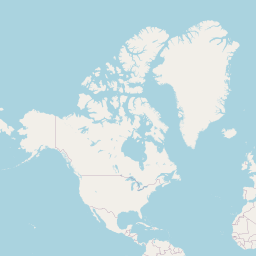

In [4]:
z = 1

url = f"https://tile.openstreetmap.org/{z}/{x}/{y}.png"

response = requests.get(url, stream=True)
Image.open(response.raw)

As we see above, changing the zoom level changed the image. What we see is the north west quadrant of the first image we obtained. If we go to zoom level 2, we see that again:

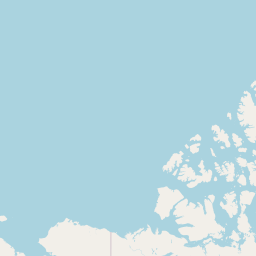

In [5]:
z = 2

url = f"https://tile.openstreetmap.org/{z}/{x}/{y}.png"

response = requests.get(url, stream=True)
Image.open(response.raw)

The structure of the WMTS is such that every time we increase the zoom level by 1, the image is split into 4 quadrants. What we've done so far is zoom in by changing the z parameter. By keeping the x and y as 0 and 0, we're always looking at the most north western tile on earth. Increasing x and y brings us further east and south respectively.

At zoom level 0, there are just 2 values for x and y: 0 and 1. So the coordinates for each tile are:
- 0, 0
- 0, 1
- 1, 1,
- 1, 0

The code below grabs each image for each coordinate and displays them in a grid. It uses a common plottling library called matplotlib to arrange the images.

https://tile.openstreetmap.org/1/0/0.png
https://tile.openstreetmap.org/1/1/0.png
https://tile.openstreetmap.org/1/0/1.png
https://tile.openstreetmap.org/1/1/1.png


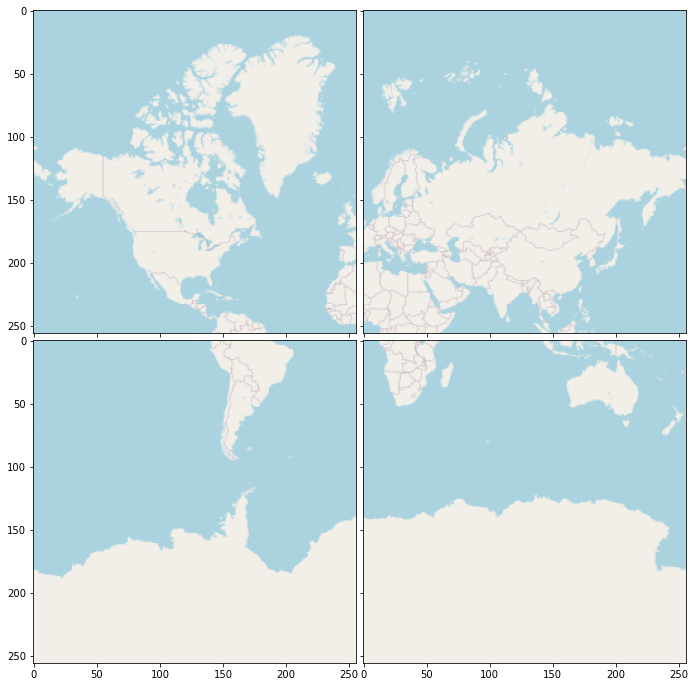

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

z = 1

coordinates = [
    [0, 0], [1, 0], [0, 1], [1, 1]
]

for ax, (x, y) in zip(grid, coordinates):
    url = f"https://tile.openstreetmap.org/{z}/{x}/{y}.png"
    response = requests.get(url, stream=True)
    print(url)
    image = Image.open(response.raw)
    ax.imshow(image)

plt.show()

If you wanted to get an image at a particular location on earth for some zoom level, all you need is the x, y and zoom value. The cells below do the math on getting a tile coorindate from a latitude and longitude pair (`deg2num`) and then the opposite (`num2deg`).

In [7]:
import math

def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lon_deg, lat_deg)

def deg2num(lon_deg, lat_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

Choosing a pair of longitude, latitude coordinates, we get the x and y coordinates for a particular tile at zoom level 14:

In [9]:
from shapely.wkt import loads as load_wkt
from shapely.geometry import Point
lon, lat = -117.98324525356294, 34.14647511468307
#lon, lat = -117.98629760742188, 34.14590795200976
lon, lat = -117.9656982421875, 34.143634820312634
boundary = load_wkt('POLYGON ((-117.98373609781264 34.14610995587136, -117.9827544093132 34.14610995587136, -117.9827544093132 34.14684027349479, -117.98373609781264 34.14684027349479, -117.98373609781264 34.14610995587136))')
zoom = 14
x, y = deg2num(lon, lat, zoom)
x, y

(2823, 6537)

Now, we have a way to get a map tile at any point on earth, for any zoom level supported by that WMTS. Note many WMTS only support up to zoom 18, but for services providing ultra high image resolutions, zoom 21 and higher are typical.

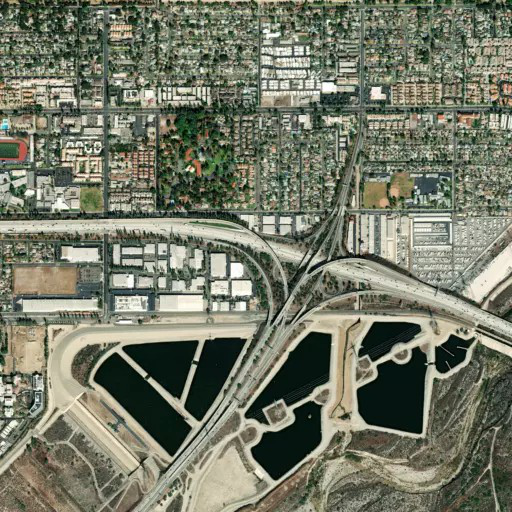

In [10]:


mapbox_satellite_url = f"https://api.mapbox.com/v4/mapbox.satellite/{zoom}/{x}/{y}@2x.jpg90?access_token=pk.eyJ1IjoicGF0d2FyZHMiLCJhIjoiY2tmZzYwenZ4MDRvaDJxcTljc3EyNWxlYSJ9.cxQNQOhFMdUbgWSoaAPrng"

response = requests.get(mapbox_satellite_url, stream=True)
image = Image.open(response.raw)
image

The point of all of the above is just to demonstrate that web maps - typically using the WMTS - can be generated by simply making requests to some API by telling it the tile coordinates and then displaying the image.

The cell below shows a more common view of a map tiles - as a collection of images that can be panned across and zoomed into. The URL named `mapbox_satellite_url` has the same format as the one we used above to grab an image, but notice the `{z}/{x}/{y}` that remains in the URL that we pass to the `TileLayer` object. The `TileLayer` object keeps track of your interactions and then calculates are replaces the `{x}`, `{y}` and `{z}` for the `x`, `y` and `z` values to fill the map view.

In [11]:
import folium


m = folium.Map(location=[45.5236, -122.6750])
folium.TileLayer(
    "https://api.mapbox.com/v4/mapbox.satellite/{zoom}/{x}/{y}@2x.jpg90?access_token=pk.eyJ1IjoicGF0d2FyZHMiLCJhIjoiY2tmZzYwenZ4MDRvaDJxcTljc3EyNWxlYSJ9.cxQNQOhFMdUbgWSoaAPrng",
    attr="Mapbox"
).add_to(m)
m

The alternative to using tiles like in the WMTS is to use just a single, large image and zoom in on that. However, some simple maths shows that to be untenable.

- the view above is roughly 4 x 2 map tiles, so 8 x 256 x 256 pixels, where each pixel is 32 bit
- to have an image with the same performance - zooming from zoom level 0 to 21 - you'd have to be able to zoom 21 times
- that would mean the image would need to contain 8 x 256 x 256 x 4^21 = 2,305,843,009,213,693,952 pixels or about half an exabyte worth of data
- alternatively, systems like WMTS allow us to grab only the data we need, requesting new data as we zoom in only for the regions we want to view

To recap, this notebook demonstrated (hopefully!):
- that WMTS is a system for requesting and serving image tiles to make maps in a web environment
- you can use a WMTS either by making individual requests for tiles, or by providing a URL to functions/objects that know how to use that URL to serve you the tiles based on how you interact with them (e.g by panning or zooming)
- that WMTS is a more efficient way of viewing images than just panning and zooming very large images